In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''  # forcing CPU to avoid GPU issues during prediction (uncomment if GPU is not available or causing issues)
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
# tf.config.optimizer.set_jit(False)
print("Devices seen by TF:", tf.config.list_physical_devices())

2025-12-09 18:47:26.764998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Devices seen by TF: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Loading the model (change to reflect the correct path)
MODEL_PATH = '/model/best_fer_cnn.keras'
best_model = tf.keras.models.load_model(MODEL_PATH)

I0000 00:00:1765327651.342754  393812 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1063 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:00:10.0, compute capability: 8.6


In [3]:
# import cv2  # for real-time demonstration

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score
)

In [4]:
# path to the dataset directory
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''  # force CPU to avoid CUDNN issues during prediction
# import tensorflow as tf
BASE_DIR = "/home/dsu/code/AAI_FER/dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_HEIGHT, IMG_WIDTH = 48, 48
BATCH_SIZE = 4
NUM_CLASSES = 7

In [5]:
def remove_blank_images(root_dir, low_thr=5, high_thr=250):
    """
    Removing images from root_dir whose mean pixel intensity
    is < low_thr or > high_thr.
    """
    removed_count = 0
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            fpath = os.path.join(class_path, fname)
            try:
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                mean_val = img.mean()
                if mean_val < low_thr or mean_val > high_thr:
                    os.remove(fpath)
                    removed_count += 1
            except Exception as e:
                print("Error reading/removing:", fpath, e)
    print(f"Removed {removed_count} blank images from {root_dir}.")

# removes blank images from training and testing directories
# remove_blank_images(TRAIN_DIR)
# remove_blank_images(TEST_DIR)


In [6]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.1  # 10% of train for validation
)

# Validation generator
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

Found 25831 images belonging to 7 classes.
Found 2866 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [7]:
import numpy as np
# Get true labels and predictions
y_true = test_gen.classes  # integer labels
y_prob = best_model.predict(test_gen)  # probabilities shape: (N_samples, NUM_CLASSES)
y_pred = np.argmax(y_prob, axis=1)

# Overall accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


2025-12-09 18:47:34.329441: I external/local_xla/xla/service/service.cc:163] XLA service 0x745cac00ef50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 18:47:34.329470: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-09 18:47:34.347377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 18:47:34.495642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-09 18:47:34.917274: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_264', 8 bytes spill stores, 8 bytes spill loads

2025-12-09 18:47:35.449266: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas war

  27/1795 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step

I0000 00:00:1765327656.947543  393855 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Test Accuracy: 64.96%
Confusion Matrix:
 [[ 585   13   43   35  150   99   32]
 [  59   30    3    4    5    7    3]
 [ 155   10  276   29  166  254  134]
 [  40    2   20 1533  115   23   41]
 [  56    3   21   79  902  150   22]
 [ 138    8   51   59  309  658   24]
 [  25    1   42   38   30   17  678]]


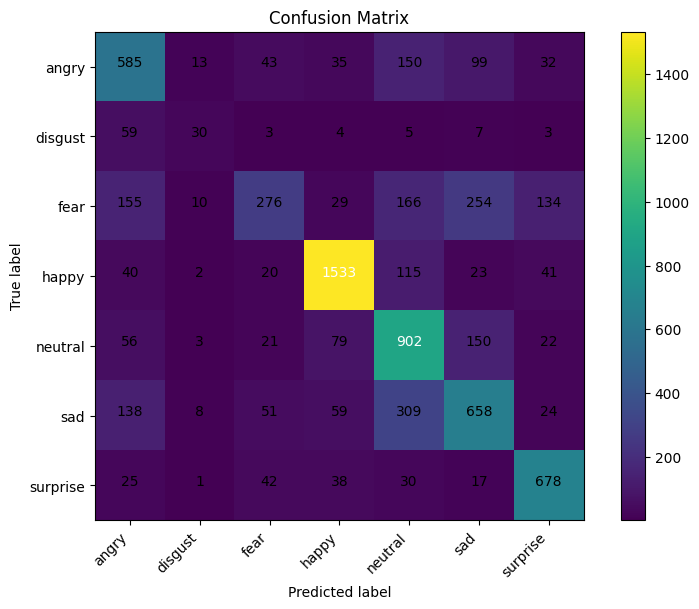

In [8]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, [idx_to_class[i] for i in range(NUM_CLASSES)])


In [9]:
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=[idx_to_class[i] for i in range(NUM_CLASSES)]
))


Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.61      0.58       957
     disgust       0.45      0.27      0.34       111
        fear       0.61      0.27      0.37      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.54      0.73      0.62      1233
         sad       0.54      0.53      0.54      1247
    surprise       0.73      0.82      0.77       831

    accuracy                           0.65      7177
   macro avg       0.61      0.58      0.58      7177
weighted avg       0.65      0.65      0.64      7177



In [10]:
# Binarize labels for ROC-AUC (one-vs-rest)
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))

macro_roc_auc = roc_auc_score(
    y_true_bin,
    y_prob,
    multi_class='ovr',
    average='macro'
)
print(f"Macro ROC-AUC (OvR): {macro_roc_auc:.4f}")


Macro ROC-AUC (OvR): 0.9084
